In [34]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_drive"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[ 2.59074015e+01 -1.54783875e-01  1.32735296e+02]
 [ 2.58843853e+01 -1.57738439e-01  1.26694237e+02]
 [ 2.59066709e+01 -1.76459958e-01  1.20824671e+02]
 [ 2.58924730e+01 -1.93742735e-01  1.15582694e+02]
 [ 2.58959435e+01 -2.01477711e-01  1.11073030e+02]
 [ 2.59048158e+01 -1.76832199e-01  1.07292697e+02]
 [ 2.59203531e+01 -1.81378237e-01  1.03687136e+02]
 [ 2.59400253e+01 -1.75989002e-01  9.96066886e+01]
 [ 2.58839110e+01 -1.98585671e-01  9.43789572e+01]
 [ 2.59337015e+01 -1.64369089e-01  8.78130276e+01]
 [ 2.59274424e+01 -1.93213809e-01  8.05997057e+01]
 [ 2.59255508e+01 -1.97904154e-01  7.29230640e+01]
 [ 2.59400884e+01 -1.59294362e-01  6.43491897e+01]
 [ 2.59105573e+01 -2.03247823e-01  5.62884271e+01]
 [ 2.59303527e+01 -1.55286546e-01  4.94243392e+01]
 [ 2.58946080e+01 -2.03801303e-01  4.85223573e+01]
 [ 2.59395208e+01 -1.60691344e-01  4.81467586e+01]
 [ 2.59341132e+01 -1.64311111e-01  4.29566400e+01]
 [ 2.59132129e+01 -2.04351217e-01  2.68919367e+01]
 [ 2.58850666e+01 -1.59614147e-

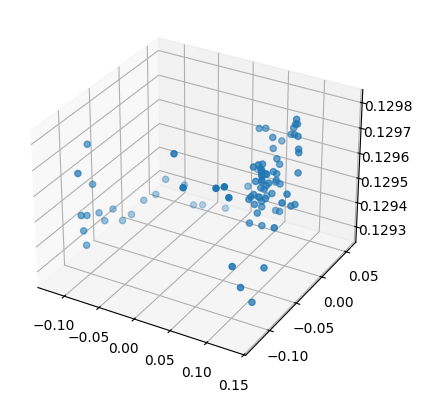

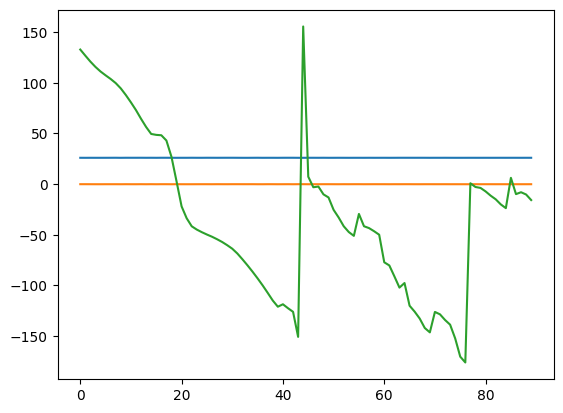

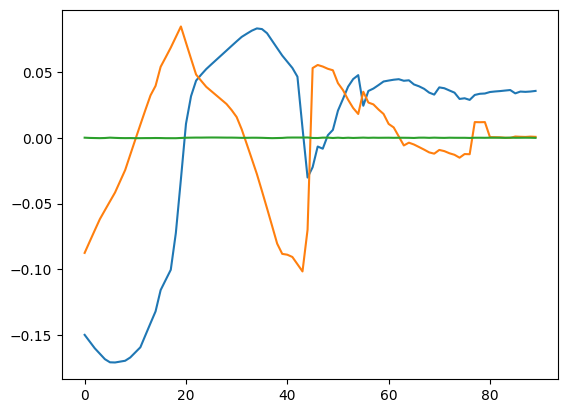

In [35]:
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

[[ 4.49771869e+01  0.00000000e+00  7.20099863e+00]
 [ 4.49771869e+01  0.00000000e+00  1.27098159e+01]
 [ 4.49771869e+01  0.00000000e+00  1.62196148e+01]
 [ 4.49771869e+01  1.27222187e-14  2.32814207e+01]
 [ 4.49771869e+01  1.27222187e-14  2.95632093e+01]
 [ 4.49771869e+01  0.00000000e+00  3.62403840e+01]
 [ 4.49771869e+01  1.27222187e-14  4.11964609e+01]
 [ 4.49771869e+01  0.00000000e+00  4.59038136e+01]
 [ 4.49771869e+01  0.00000000e+00  5.09350131e+01]
 [ 4.49771869e+01  0.00000000e+00  5.56281952e+01]
 [ 4.49771869e+01  0.00000000e+00  6.08285758e+01]
 [ 4.49771869e+01  1.27222187e-14  6.73237624e+01]
 [ 4.49771869e+01  0.00000000e+00  7.15962420e+01]
 [ 4.49771869e+01  0.00000000e+00  7.87423162e+01]
 [ 4.49771869e+01  0.00000000e+00  8.58544386e+01]
 [ 4.49771869e+01  1.27222187e-14  9.11327127e+01]
 [ 4.49771869e+01  1.27222187e-14  9.73857202e+01]
 [ 4.49771869e+01  0.00000000e+00  1.02302081e+02]
 [ 4.49771869e+01  1.27222187e-14  1.09471255e+02]
 [ 4.49771869e+01  0.00000000e+

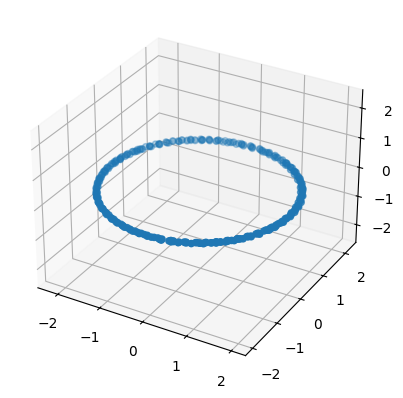

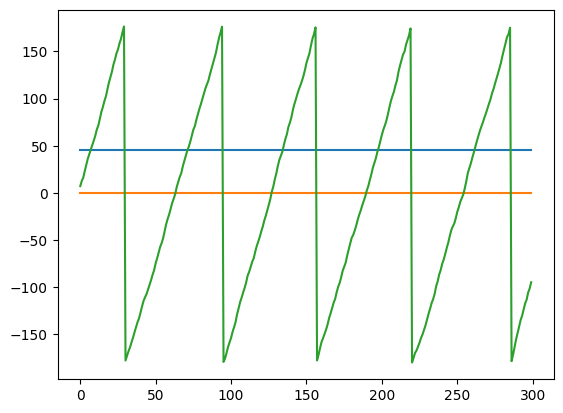

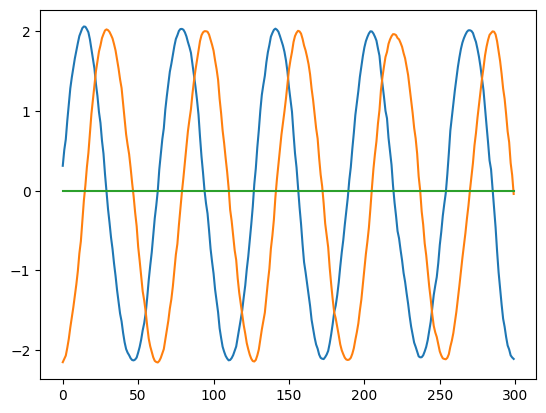

In [36]:
with open(os.path.join(DATA_PATH, "ground_truth.json"), "r") as f:
    ground_truth = json.load(f)
    
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

points = []
euler_angle = []
for frame in ground_truth["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()